In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

In [2]:
import datatools as dt

In [17]:
# Create synthetic categorical data
from sklearn.datasets import make_circles,make_swiss_roll,make_blobs

n_samples=100

X,y=make_blobs(n_features=64,n_samples=n_samples,centers=5,random_state=42)
X2,y2=make_circles(n_samples=1000,noise=0.01,random_state=42)

In [18]:
len(X),len(y)

(100, 100)

In [19]:
df=pd.DataFrame({"X1":X[:,0],
                 "X2":X[:,1],
                "label":y})
df.head()

,X1,X2,label
0,-5.410681,-0.498749,1
1,-4.212849,2.171519,1
2,8.234209,5.509536,4
3,-8.755057,-0.349001,2
4,-4.298870,-0.603630,1


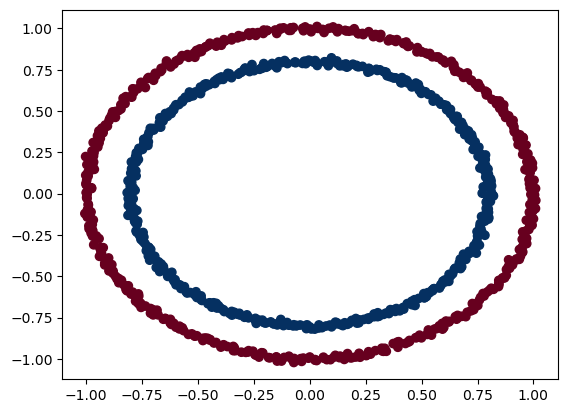

In [21]:
plt.scatter(X2[:,0],X2[:,1],c=y2,cmap="RdBu")

In [26]:
X2=torch.from_numpy(X2).type(torch.float)
y2=torch.from_numpy(y2).type(torch.float)

TypeError: expected np.ndarray (got Tensor)

In [27]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [28]:
print(f"X:{type(X)}, X2: {type(X2)}, y: {type(y)}, y2: {type(y2)}")

X:<class 'torch.Tensor'>, X2: <class 'torch.Tensor'>, y: <class 'torch.Tensor'>, y2: <class 'torch.Tensor'>


In [35]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,y,
                                              random_state=42,
                                              test_size=0.3)
X2_train,X2_test,Y2_train,Y2_test=train_test_split(X2,y2,
                                              random_state=42,
                                              test_size=0.3)

In [30]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [31]:
class Pass(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2,out_features=5)
        self.layer2=nn.Linear(in_features=5,out_features=1)
        
        self.two_layers=nn.Sequential(nn.Linear(in_features=2,out_features=5),
                          nn.Linear(in_features=5,out_features=1))
    def forward(self,x):
        return self.two_layers(x)

In [32]:
model=Pass().to(device)

In [36]:
with torch.inference_mode():
    yhat=model(X2_train[0])

In [37]:
yhat

tensor([0.3234])

In [38]:
criterion=nn.BCEWithLogitsLoss()
optim=torch.optim.SGD(model.parameters(),lr=0.1)

from sklearn.metrics import accuracy_score

In [40]:
Y2_train=Y2_train.reshape(700,1)

In [41]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [42]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(in_features=2,out_features=5),
                                nn.Linear(in_features=5,out_features=1))
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [43]:
model=LinearNet().to(device)

In [45]:
with torch.inference_mode():
    y_logits=model(X2_train)[:5]
y_logits

tensor([[-0.0917],
        [-0.1427],
        [ 0.2422],
        [ 0.2789],
        [-0.1118]])

In [46]:
y_proba=torch.sigmoid(y_logits)
y_proba

tensor([[0.4771],
        [0.4644],
        [0.5603],
        [0.5693],
        [0.4721]])

In [47]:
y_preds=torch.round(y_proba)
y_preds

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [48]:
criterion=nn.BCEWithLogitsLoss()
optim=torch.optim.SGD(params=model.parameters(),
                     lr=0.01)

In [50]:
###TRAINING SIMPLE NEURAL NETWORK ON THE CIRCLES DATA

epochs=500

for epoch in range(epochs):
    model.train()
    
    y_logits=model(X2_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))
    
    metric=accuracy_fn(Y2_train.squeeze(),y_preds)
    
    loss=criterion(y_logits,Y2_train.squeeze())
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    model.eval()
    
    with torch.inference_mode():
        test_logits=model(X2_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        
    test_acc=accuracy_fn(Y2_test.squeeze(),test_preds)
    if epoch%10==0:
        print(f"Epoch: {epoch:3d} || Accuracy: {metric:.5f}% || Loss: {loss:.10f} || Test Accuracy: {test_acc:.5f}\n")

Epoch:   0 || Accuracy: 50.85714% || Loss: 0.6957281828 || Test Accuracy: 52.33333

Epoch:  10 || Accuracy: 50.85714% || Loss: 0.6956623197 || Test Accuracy: 52.33333

Epoch:  20 || Accuracy: 50.71429% || Loss: 0.6955983043 || Test Accuracy: 52.33333

Epoch:  30 || Accuracy: 50.71429% || Loss: 0.6955359578 || Test Accuracy: 52.66667

Epoch:  40 || Accuracy: 50.71429% || Loss: 0.6954753995 || Test Accuracy: 52.66667

Epoch:  50 || Accuracy: 50.71429% || Loss: 0.6954164505 || Test Accuracy: 52.66667

Epoch:  60 || Accuracy: 50.71429% || Loss: 0.6953589916 || Test Accuracy: 52.66667

Epoch:  70 || Accuracy: 50.85714% || Loss: 0.6953030229 || Test Accuracy: 52.33333

Epoch:  80 || Accuracy: 51.00000% || Loss: 0.6952484846 || Test Accuracy: 52.33333

Epoch:  90 || Accuracy: 51.00000% || Loss: 0.6951953173 || Test Accuracy: 52.33333

Epoch: 100 || Accuracy: 51.00000% || Loss: 0.6951434612 || Test Accuracy: 52.33333

Epoch: 110 || Accuracy: 50.85714% || Loss: 0.6950929165 || Test Accuracy: 52

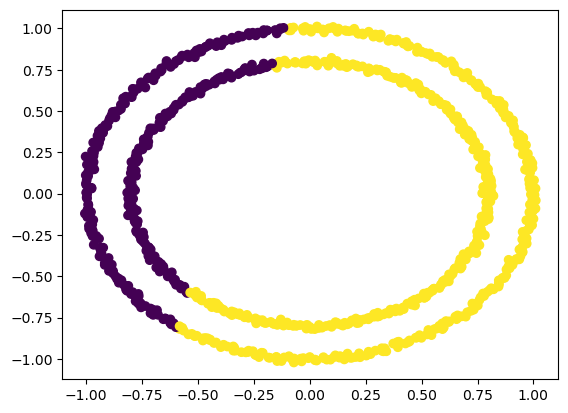

In [52]:
## VISUALIZING THE CLASSIFICATION RESULTS

with torch.inference_mode():
    logits=model(X2).squeeze()
    preds=torch.round(torch.sigmoid(logits))
plt.scatter(X2[:,0],X2[:,1],c=preds)

In [53]:
## DEFINING ANOTHER NEURAL NETWORK (MORE COMPLEX)

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(in_features=2,out_features=16),
                                 nn.ReLU(),
                                 nn.Linear(in_features=16,out_features=32),
                                 nn.ReLU(),
                                 nn.Linear(in_features=32,out_features=16),
                                 nn.ReLU(),
                                 nn.Linear(in_features=16,out_features=1))
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [55]:
net=NeuralNet()

criterion=nn.BCEWithLogitsLoss()
optim=torch.optim.Adam(params=net.parameters())

In [56]:
### TRAINING THE NEW NETWORK


epochs=140

for epoch in range(epochs):
    net.train()
    y_logits=net(X2_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))
    loss=criterion(y_logits,Y2_train.squeeze())
    acc=accuracy_fn(Y2_train.squeeze(),y_preds)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    net.eval()
    with torch.inference_mode():
        test_logit=net(X2_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logit))
        test_loss=criterion(test_logit,Y2_test.squeeze())
        test_acc=accuracy_fn(Y2_test.squeeze(),test_pred)
        
    if epoch%10==0:
        print(f"Epoch: {epoch:2d} || Loss: {loss:.5f} || Accuracy: {acc:.3f}% \
        || Test Loss: {test_loss:.5f} || Test Accuracy: {test_acc:.3f}% \n")

Epoch:  0 || Loss: 0.70203 || Accuracy: 49.143%         || Test Loss: 0.69601 || Test Accuracy: 52.000% 

Epoch: 10 || Loss: 0.69801 || Accuracy: 49.143%         || Test Loss: 0.69355 || Test Accuracy: 52.000% 

Epoch: 20 || Loss: 0.69476 || Accuracy: 49.143%         || Test Loss: 0.69207 || Test Accuracy: 52.000% 

Epoch: 30 || Loss: 0.69246 || Accuracy: 49.143%         || Test Loss: 0.69129 || Test Accuracy: 52.000% 

Epoch: 40 || Loss: 0.69006 || Accuracy: 52.857%         || Test Loss: 0.68968 || Test Accuracy: 51.333% 

Epoch: 50 || Loss: 0.68697 || Accuracy: 53.857%         || Test Loss: 0.68689 || Test Accuracy: 54.667% 

Epoch: 60 || Loss: 0.68301 || Accuracy: 55.571%         || Test Loss: 0.68295 || Test Accuracy: 57.333% 

Epoch: 70 || Loss: 0.67727 || Accuracy: 62.000%         || Test Loss: 0.67691 || Test Accuracy: 64.667% 

Epoch: 80 || Loss: 0.66940 || Accuracy: 71.286%         || Test Loss: 0.66882 || Test Accuracy: 73.333% 

Epoch: 90 || Loss: 0.65760 || Accuracy: 74.571

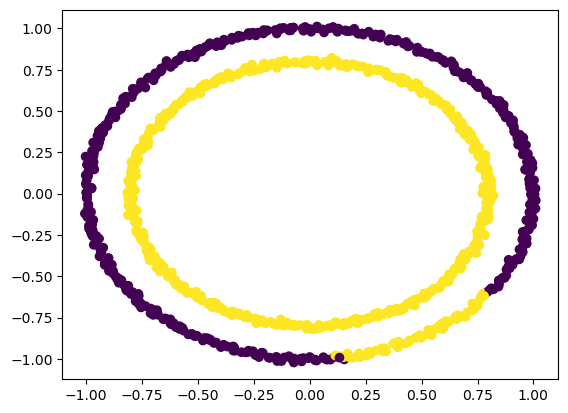

In [58]:
## LET'S SEE THE CLASSIFICATION RESULTS HERE

with torch.inference_mode():
    logits=net(X2).squeeze()
    preds=torch.round(torch.sigmoid(logits))
plt.scatter(X2[:,0],X2[:,1],c=preds)

SEEMS LIKE THIS MODEL CAPTURES THE COMPLEXITY OF THE DATA MUCH BETTER DEFINITELY DUE TO THE MODEL HAVING MORE PARAMETERS

NOTICE HOW I DON'T TRAIN TO PERFECTION (100% ACCURACY) TO PREVENT OVERFITTING I LEAVE SOME ROOM FOR GENERALIZATION HOWEVER THIS IS NOT QUITE FULLY THE GENERALIZATION LEVEL FOR REAL-WORLD APPLICATIONS THIS MODEL IS STILL CONSIDERED OVERFITTED CUTTING OFF TRAINING EARLY IS JUST ONE OF THE METHODS. I WILL DISCUSS MORE LATER OR IN LATER PROJECTS.

In [66]:
## HERE WE DECLARE OUR FIRST AUTOENCODER


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(nn.Linear(64,32),
                                  nn.ReLU(),
                                  nn.Linear(32,16),
                                  nn.ReLU(),
                                  nn.Linear(16,10),
                                  nn.ReLU())
        
        self.decoder=nn.Sequential(nn.Linear(10,16),
                                  nn.ReLU(),
                                  nn.Linear(16,32),
                                  nn.ReLU(),
                                  nn.Linear(32,64),
                                  nn.Sigmoid())
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded, decoded

In [67]:
model=AutoEncoder()
criterion=nn.MSELoss()
optim=torch.optim.Adam(params=model.parameters(),lr=1e-4)
epochs=30

X.shape

torch.Size([100, 64])

In [68]:
## INITIALIZING THE ENCODE AND DECODE TENSORS

min_val=torch.zeros(64)
max_val=torch.zeros(64)
rng=torch.zeros(64)
for i in range(64):
    min_val[i]=torch.min(X[:,i])
    max_val[i]=torch.max(X[:,i])
    rng[i]=max_val[i]-min_val[i]

encode=torch.zeros(100,10,requires_grad=False)
decode=torch.zeros(100,64,requires_grad=False)

In [70]:
## TRAINING OUR FIRST AUTOENCODER

epoch_count=[]
loss_count=[]
epochs=120

for epoch in range(epochs):
    model.train()
    _,out=model(X)
    loss_count.append(loss)
    epoch_count.append(epoch)
    loss=criterion(out,torch.sigmoid(X))
    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch%5==0:
        print(f"Epoch: {epoch:3d} || Loss: {loss:.10f} \n")
        
encode=_

# Decoder output is scaled to match the data that was given in.
decode=min_val+rng*out

Epoch:   0 || Loss: 0.2052102983 

Epoch:   5 || Loss: 0.2049301267 

Epoch:  10 || Loss: 0.2046570927 

Epoch:  15 || Loss: 0.2043858021 

Epoch:  20 || Loss: 0.2041126788 

Epoch:  25 || Loss: 0.2038373202 

Epoch:  30 || Loss: 0.2035612166 

Epoch:  35 || Loss: 0.2032733858 

Epoch:  40 || Loss: 0.2029728889 

Epoch:  45 || Loss: 0.2026630342 

Epoch:  50 || Loss: 0.2023423165 

Epoch:  55 || Loss: 0.2020027488 

Epoch:  60 || Loss: 0.2016350627 

Epoch:  65 || Loss: 0.2012331784 

Epoch:  70 || Loss: 0.2007959783 

Epoch:  75 || Loss: 0.2003182769 

Epoch:  80 || Loss: 0.1997966319 

Epoch:  85 || Loss: 0.1992273778 

Epoch:  90 || Loss: 0.1986062080 

Epoch:  95 || Loss: 0.1979296356 

Epoch: 100 || Loss: 0.1971979886 

Epoch: 105 || Loss: 0.1964109987 

Epoch: 110 || Loss: 0.1955632269 

Epoch: 115 || Loss: 0.1946481466 



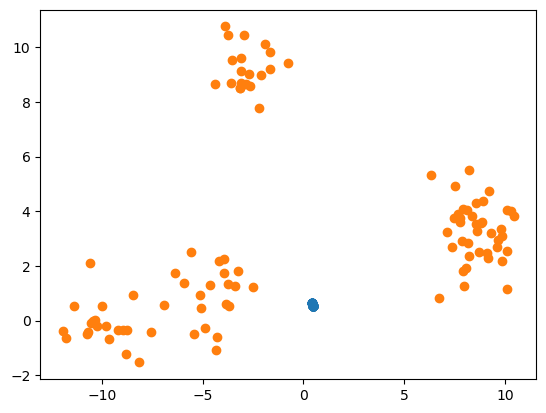

In [71]:
out=out.detach().numpy()
plt.scatter(out[:,0],out[:,1])
plt.scatter(X[:,0],X[:,1])

In [72]:
c,d=model(X)

d

decode.detach()

X

tensor([[-5.4107, -0.4987, -8.7039,  ..., -0.2883,  6.1309,  7.1711],
        [-4.2128,  2.1715, -8.1881,  ..., -1.2673,  7.0697,  6.7791],
        [ 8.2342,  5.5095,  0.1590,  ..., -8.3081, -7.5573, -5.6124],
        ...,
        [-2.1831,  7.7632,  5.5639,  ..., -4.3882,  5.7164, -2.1646],
        [-2.8578,  8.6650,  4.3182,  ..., -3.1973,  6.4247, -2.7394],
        [-9.7883, -0.1965, -1.7410,  ..., -3.3333, -8.5476,  8.6566]])

IndexError: index 100 is out of bounds for dimension 0 with size 100

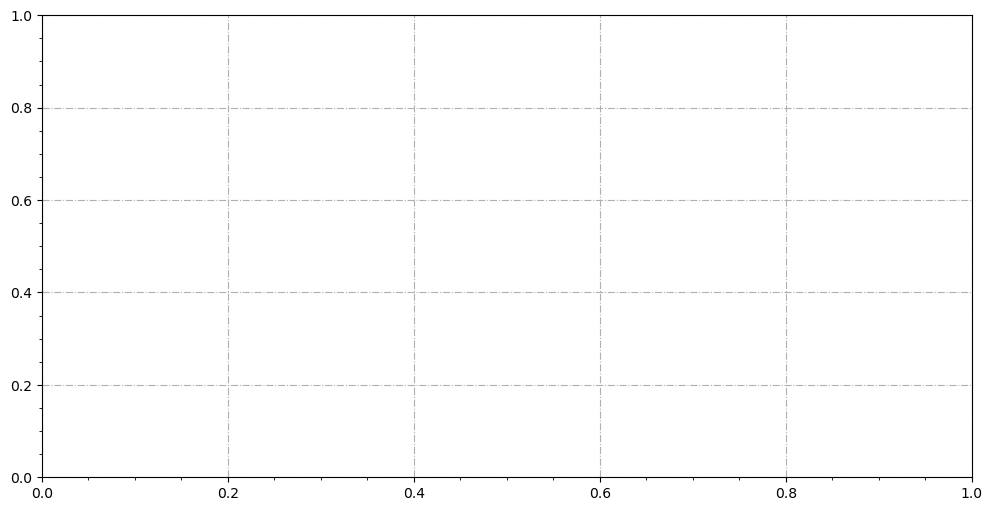

In [73]:
plt.figure(figsize=(12,6))
plt.minorticks_on()
plt.grid(linestyle='-.')
plt.scatter(range(0,64),X[180,:])
plt.scatter(range(0,64),decode[180,:].detach().numpy())
plt.show()

In [ ]:
df_X=pd.DataFrame()
for i in range(64):
    df_X[i]=X[:,i]

In [ ]:
df_X["Anomaly"]=0

In [ ]:
threshold=1.960
anom=[]
recon_err=[]
mse=nn.MSELoss()
for i in range(500):
    with torch.inference_mode():
        _,output=model(X[i,:])
        recon_err.append(mse(output,X[i,:]))

mean=np.mean(recon_err)
std=np.std(recon_err)
recon_err=[(x-mean)/std for x in recon_err]
anom=[1 if x>threshold or x<-threshold else 0 for x in recon_err]
df_X["Anomaly"]=anom

In [ ]:
df_X[df_X["Anomaly"]==1]

In [ ]:
df_X[df_X["Anomaly"]==1]

In [ ]:
X[0,:].unsqueeze(dim=0).shape

In [ ]:
output.shape

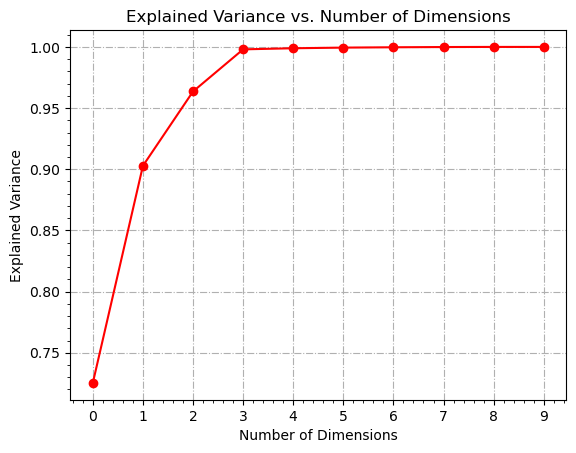

In [75]:
# Assuming 'reduced_data' contains the reduced-dimensional representations obtained from the encoder
# Calculate the covariance matrix of the reduced data
cov_matrix = np.cov(encode.detach().numpy(), rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvalues in descending order
eigenvalues = eigenvalues[::-1]

# Calculate the explained variance
explained_variance = eigenvalues / np.sum(eigenvalues)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# You can also plot the explained variance to visualize it
plt.plot(cumulative_explained_variance,marker='o',color="red")
plt.xlabel("Number of Dimensions")
plt.xticks(range(0,10))
plt.minorticks_on()
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs. Number of Dimensions")
plt.grid(linestyle="-.")
plt.show()


In [ ]:
plt.bar(range(0,10),explained_variance)
plt.xticks(range(0,10))
plt.show()

In [ ]:
class decomposer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(nn.Linear(64,32),
                                  nn.ReLU(),
                                   nn.Linear(32,16),
                                  nn.ReLU(),
                                  nn.Linear(16,8),
                                  nn.ReLU(),
                                  nn.Linear(8,3),
                                  nn.ReLU())
        self.decoder=nn.Sequential(nn.Linear(3,8),
                                  nn.ReLU(),
                                   nn.Linear(8,16),
                                  nn.ReLU(),
                                  nn.Linear(16,32),
                                  nn.ReLU(),
                                  nn.Linear(32,64),
                                  nn.Sigmoid())
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded,decoded

In [ ]:
decomp=decomposer()
criterion=nn.MSELoss()
optim=torch.optim.Adam(decomp.parameters(),lr=2e-3)

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [ ]:
X_test.requires_grad_()
X_train.requires_grad_()

In [ ]:
epochs=300
loss_count=[]
test_count=[]
epoch_count=[]

for epoch in range(epochs):
    decomp.train()
    enc,dec=decomp(X_train)
    loss=criterion(dec,torch.sigmoid(X_train))
    loss_count.append(loss.detach().numpy())
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    decomp.eval()
    
    with torch.inference_mode():
        _,test=decomp(X_test)
        test_loss=criterion(test,torch.sigmoid(X_test))
        test_count.append(test_loss.detach().numpy())
        
    epoch_count.append(epoch)
    
    if epoch%10==0:
        print(f"Epoch: {epoch:3d} || Train Loss: {loss:.10f} || Test Loss: {test_loss:.10f} \n")

In [ ]:
plt.plot(epoch_count,loss_count,c='blue',label="Test Loss")
plt.plot(epoch_count,test_count,c='red',label="Test Loss")
plt.title("Learning Curve",fontsize=20)
plt.xlabel("Epoch",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.grid(linestyle='-.')
plt.legend()
plt.minorticks_on()
plt.show()

In [ ]:
dt.lr_curve(epoch_count,loss_count,test_count)

In [ ]:
X_red=encode[:,:3]

In [ ]:
X_red

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10)
pca.fit(X)
wcss=pca.explained_variance_ratio_

In [ ]:
plt.bar(range(0,10),wcss)
plt.xticks(range(0,10))
plt.title("PCA Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Dimensions")
plt.show()

In [ ]:
pca=PCA(n_components=10)
pca.fit(encode.detach().numpy())
wcss=pca.explained_variance_ratio_

In [ ]:
plt.bar(range(0,10),wcss)
plt.xticks(range(0,10))
plt.title("PCA Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Dimensions")
plt.show()

In [ ]:
from sklearn.clusters import DBSCAN